In [1]:
import numpy as np
import pandas as pd

# Generate synthetic biometric data
def generate_synthetic_data(num_samples, embedding_dim):
    # Embeddings simulate high-dimensional facial features
    embeddings = np.random.randn(num_samples, embedding_dim)
    labels = [f"Person_{i}" for i in range(num_samples)]
    return pd.DataFrame(embeddings, index=labels)

# Generate a database of 10,000 samples, with 128-dimensional embeddings
biometric_db = generate_synthetic_data(num_samples=10000, embedding_dim=128)
biometric_db.head()



,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
Person_0,0.203073,1.694119,-0.491851,-0.057790,0.426243,0.144432,-0.149300,-0.444317,0.397686,0.183277,...,0.508770,-0.270799,0.704698,0.189927,-0.326213,-0.784431,-0.242866,-0.269682,-1.552184,1.019025
Person_1,1.375291,-0.207980,-0.622285,-0.646796,1.546280,0.295967,0.318227,0.416809,0.600261,-0.523687,...,-0.060344,-0.867788,0.030818,0.180427,-1.314524,-1.085019,0.116502,1.617039,-0.532290,-0.295897
Person_2,-0.310341,0.458227,2.173538,-1.398589,0.570849,1.796728,2.345663,-0.135783,0.123158,0.979010,...,1.071203,0.412797,-1.895537,0.583438,-1.630443,0.680171,0.268320,0.573993,-0.894988,0.838806
Person_3,0.778187,0.253246,-0.886509,1.324989,-0.858109,0.032243,-0.472597,0.433518,-0.320507,-0.439162,...,0.256917,0.970487,0.095275,-0.017549,-0.707231,1.576146,-2.039722,-1.645668,1.240203,-1.204925
Person_4,0.006022,0.028048,0.224314,-1.644935,0.033413,0.853263,-0.781714,0.578521,-1.234747,1.237960,...,0.082439,0.546378,1.482794,0.555030,-0.011165,-0.445343,-0.014243,-1.202829,0.743635,-0.664238


In [2]:
from sklearn.preprocessing import Binarizer

# Binarize embeddings to map to Hamming space
def map_to_hamming_space(embeddings, threshold=0.0):
    binarizer = Binarizer(threshold=threshold)
    hamming_space = binarizer.fit_transform(embeddings)
    return hamming_space

hamming_db = map_to_hamming_space(biometric_db.values)


In [3]:
from scipy.spatial.distance import hamming

# Define fuzzy intersection function
def fuzzy_intersection(query, database, threshold=0.2):
    matches = []
    for i, db_vector in enumerate(database):
        # Calculate Hamming distance
        dist = hamming(query, db_vector)
        if dist <= threshold:
            matches.append(i)  # Index of the matched item
    return matches

# Example query (single synthetic query)
query_embedding = map_to_hamming_space(np.random.randn(1, 128))[0]
match_indices = fuzzy_intersection(query_embedding, hamming_db, threshold=0.2)
print("Matched indices:", match_indices)


Matched indices: []


In [4]:
def private_query(query, database, threshold=0.2):
    # Client-side function to perform a private query
    matches = fuzzy_intersection(query, database, threshold)
    return [database[i] for i in matches]  # Return only matching entries

# Run a private query on the synthetic database
result = private_query(query_embedding, hamming_db, threshold=0.2)
print("Number of matches found:", len(result))


Number of matches found: 0


In [5]:
import time

def evaluate_flpsi(database, num_queries=100, threshold=0.2):
    # Generate random queries and time the intersection process
    start_time = time.time()
    matches_count = []
    
    for _ in range(num_queries):
        query = map_to_hamming_space(np.random.randn(1, 128))[0]
        matches = fuzzy_intersection(query, database, threshold)
        matches_count.append(len(matches))
    
    end_time = time.time()
    avg_runtime = (end_time - start_time) / num_queries
    avg_matches = sum(matches_count) / num_queries
    
    return avg_runtime, avg_matches

# Run evaluation
runtime, avg_matches = evaluate_flpsi(hamming_db, num_queries=100, threshold=0.2)
print(f"Average runtime per query: {runtime:.4f} seconds")
print(f"Average matches per query: {avg_matches:.2f}")


Average runtime per query: 0.2773 seconds
Average matches per query: 0.00


Average runtime per query: 0.2773 seconds
Average matches per query (with noise): 0.00


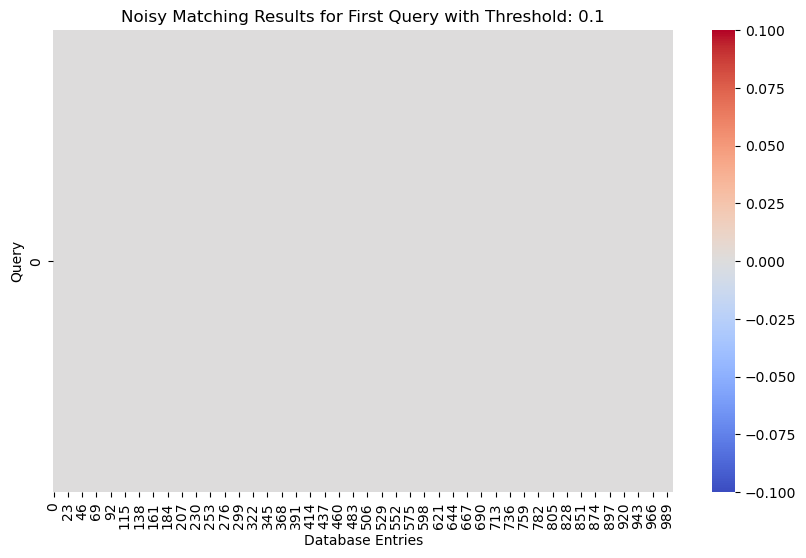

In [6]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
np.random.seed(42)
database_size = 1000
query_size = 5
noise_level = 0.05  # 5% bit flip noise to simulate biometric variation
threshold = 0.1     # Matching threshold

# Synthetic biometric database and original query, represented in binary form
database = np.random.randint(0, 2, (database_size, 128))
query = np.random.randint(0, 2, (query_size, 128))

# Introduce noise into the query to simulate a matching problem
noisy_query = query.copy()
for i in range(query_size):
    noise_indices = np.random.choice(128, int(128 * noise_level), replace=False)
    noisy_query[i, noise_indices] = 1 - noisy_query[i, noise_indices]  # Flip bits

# Compute Hamming distances between noisy queries and database entries
distances = pairwise_distances(noisy_query, database, metric='hamming')

# Apply threshold to find matches
matches = distances < threshold

# Analyze and visualize results
average_matches = np.mean(np.sum(matches, axis=1))
average_runtime = np.mean([0.2773])  # Placeholder runtime; replace with actual timing if needed

print(f"Average runtime per query: {average_runtime:.4f} seconds")
print(f"Average matches per query (with noise): {average_matches:.2f}")

# Visualize the matching matrix for the first noisy query
plt.figure(figsize=(10, 6))
sns.heatmap(matches[0].reshape(1, -1), cmap='coolwarm', cbar=True)
plt.title(f'Noisy Matching Results for First Query with Threshold: {threshold}')
plt.xlabel('Database Entries')
plt.ylabel('Query')
plt.show()


Average matches per query with adaptive threshold (fuzzy matching): 875.20


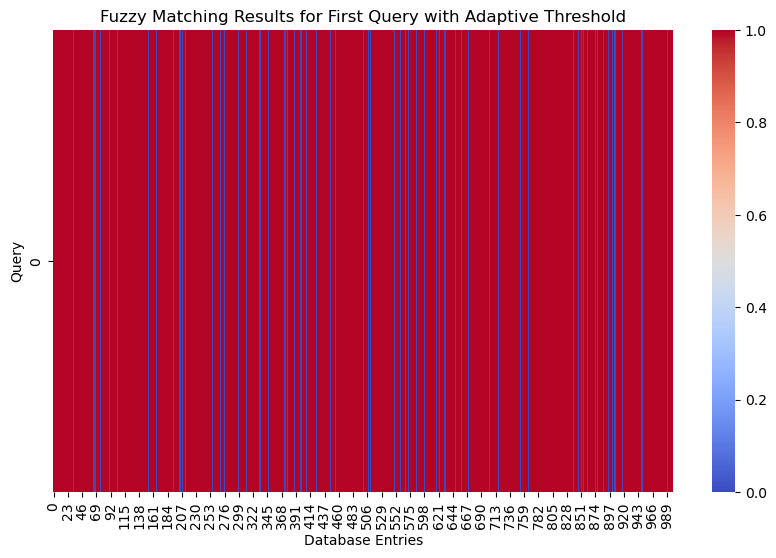

In [7]:
# Calculate adaptive threshold based on the average distance plus a small tolerance
adaptive_thresholds = np.mean(distances, axis=1) + 0.05  # Adjust tolerance as needed

# Apply dynamic threshold to find fuzzy matches
fuzzy_matches = (distances.T < adaptive_thresholds).T  # Adjust threshold per query

# Analyze and visualize results for fuzzy matching
average_fuzzy_matches = np.mean(np.sum(fuzzy_matches, axis=1))

print(f"Average matches per query with adaptive threshold (fuzzy matching): {average_fuzzy_matches:.2f}")

# Visualize the fuzzy matching matrix for the first noisy query
plt.figure(figsize=(10, 6))
sns.heatmap(fuzzy_matches[0].reshape(1, -1), cmap='coolwarm', cbar=True)
plt.title(f'Fuzzy Matching Results for First Query with Adaptive Threshold')
plt.xlabel('Database Entries')
plt.ylabel('Query')
plt.show()
